Text(0, 0.5, 'Speed\n[cm / s]')

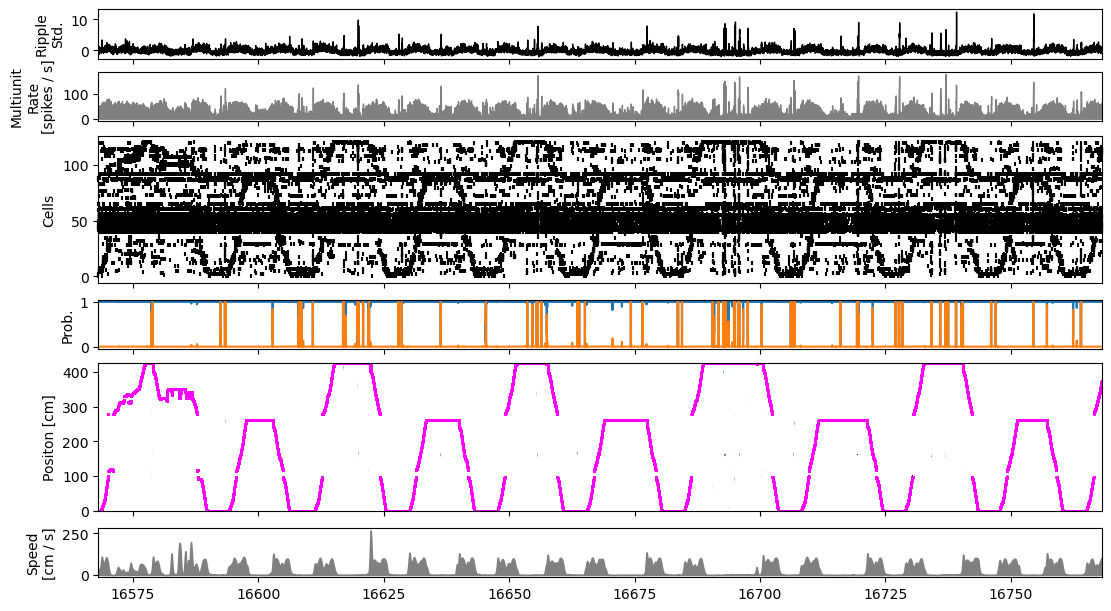

In [1]:
import numpy as np
import matplotlib.pyplot as plt


data = np.load('Jaq_03_12_visualization_data.npy', allow_pickle=True)

time_slice = slice(100_000, 200_000)

fig, axes = plt.subplots(6, 1, figsize=(11, 6), sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [1, 1, 3, 1, 3, 1]}, dpi=100)

start_time, end_time = data[5]['time'][time_slice][[0, -1]]
ripple_time_slice = (data[0]['time'] > start_time) & (data[0]['time'] < end_time)

axes[0].fill_between(data[0]['time'][ripple_time_slice], data[0]['data'][ripple_time_slice], color='black')
axes[0].set_ylabel("Ripple\nStd.")


axes[1].fill_between(data[1]['time'][time_slice], data[1]['data'][time_slice], color='grey')
axes[1].set_ylabel("Multiunit\nRate\n[spikes / s]")

spikes_time_slice = (data[2]['spike_times'] > start_time) & (data[2]['spike_times'] < end_time)

axes[2].scatter(data[2]['spike_times'][spikes_time_slice], data[2]['cell_id'][spikes_time_slice],
                clip_on=False, s=10, color='black', marker='|', rasterized=True)
axes[2].set_ylabel('Cells')

axes[3].plot(data[5]['time'][time_slice], data[5]['data'][time_slice])
axes[3].set_ylabel('Prob.')

axes[4].pcolormesh(data[6]['time'][time_slice], data[6]['position'], data[6]['data'][time_slice].T, shading='auto', cmap='bone_r')
axes[4].scatter(data[3]['time'][time_slice], data[3]['data'][time_slice], color='magenta', s=1)
axes[4].set_ylabel('Positon [cm]')

axes[5].fill_between(data[4]['time'][time_slice], data[4]['data'][time_slice], color='grey')
axes[5].set_ylabel('Speed\n[cm / s]')

In [5]:
from src.load_data import load_data

epoch_key = 'Jaq', 3, 12

data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=30,
                 min_distance_traveled=50,
                 )

In [8]:
data.keys()

dict_keys(['position_info', 'tetrode_info', 'neuron_info', 'spikes', 'dio', 'dio_indicator', 'track_graph', 'edge_order', 'edge_spacing', 'ripple_times', 'ripple_labels', 'ripple_filtered_lfps', 'ripple_consensus_trace', 'ripple_lfps', 'ripple_consensus_trace_zscore', 'instantaneous_ripple_power_change', 'is_ripple', 'multiunits', 'multiunit_spikes', 'multiunit_firing_rate', 'multiunit_high_synchrony_times', 'multiunit_high_synchrony_labels', 'multiunit_rate_change', 'multiunit_rate_zscore', 'is_multiunit_high_synchrony'])

In [10]:
SortedSpikesClassifier?

Init signature:
SortedSpikesClassifier(
    environments=Environment(environment_name='', place_bin_size=2.0, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True),
    observation_models=None,
    continuous_transition_types=[[RandomWalk(environment_name='', movement_var=6.0, movement_mean=0.0), Uniform(environment_name='', environment2_name=None)], [Uniform(environment_name='', environment2_name=None), Uniform(environment_name='', environment2_name=None)]],
    discrete_transition_type=DiagonalDiscrete(diagonal_value=0.98),
    initial_conditions_type=UniformInitialConditions(),
    infer_track_interior=True,
    knot_spacing=10,
    spike_model_penalty=10.0,
)
Docstring:     
Attributes
----------
environment : Environment
    The spatial environment and topology to fit
continuous_transition_types : tuple of tuples
    The continuous state transition class instances to fit
discrete_transition_type : Discrete
   

In [12]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity

environment = Environment(
    place_bin_size=2.5,
    track_graph=data['track_graph'],
    edge_order=data['edge_order'],
    edge_spacing=data['edge_spacing'],
)
continuous_transition_types = [[RandomWalk(movement_var=6.0),  Uniform()],
                                [Uniform(), Uniform()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
    knot_spacing=8.0
)
classifier.fit(data['position_info'].linear_position, data['spikes'])
results = classifier.predict(data['spikes'], state_names=['Continuous', 'Fragmented'])



distributed.diskutils - INFO - Found stale lock file and directory '/stelmo/edeno/pose_analysis/notebooks/dask-worker-space/worker-6d6t8uye', purging
distributed.diskutils - INFO - Found stale lock file and directory '/stelmo/edeno/pose_analysis/notebooks/dask-worker-space/worker-8c6ud2fi', purging
distributed.diskutils - INFO - Found stale lock file and directory '/stelmo/edeno/pose_analysis/notebooks/dask-worker-space/worker-y_5jg_q4', purging
distributed.diskutils - INFO - Found stale lock file and directory '/stelmo/edeno/pose_analysis/notebooks/dask-worker-space/worker-30adwgsc', purging
distributed.diskutils - INFO - Found stale lock file and directory '/stelmo/edeno/pose_analysis/notebooks/dask-worker-space/worker-gs_nqmyy', purging
distributed.diskutils - INFO - Found stale lock file and directory '/stelmo/edeno/pose_analysis/notebooks/dask-worker-space/worker-94pa_7tp', purging


In [13]:
results

<xarray.Dataset>
Dimensions:            (time: 448713, state: 2, position: 161)
Coordinates:
  * time               (time) int64 0 1 2 3 4 ... 448709 448710 448711 448712
  * position           (position) float64 1.249 3.747 6.246 ... 419.9 422.4
  * state              (state) <U10 'Continuous' 'Fragmented'
Data variables:
    likelihood         (time, state, position) float64 2.22e-16 2.22e-16 ... 1.0
    causal_posterior   (time, state, position) float64 1.11e-16 ... 0.000438
    acausal_posterior  (time, state, position) float64 2.045e-20 ... 0.000438
Attributes:
    data_log_likelihood:  -304093.93797469

In [24]:
from scipy.stats import zscore

ripple_consensus_trace = zscore(data['ripple_consensus_trace'], nan_policy='omit')
ripple_consensus_trace_time = np.asarray(ripple_consensus_trace.index / np.timedelta64(1, 's'))

ripple_zscore = {
    'type': 'zscore_ripple_consensus_trace',
    'time': ripple_consensus_trace_time,
    'data': np.asarray(ripple_consensus_trace).squeeze(),
    'units': 'std',
}

multiunit_firing = (
    data["multiunit_firing_rate"]
    .reset_index(drop=True)
    .set_index(
        data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
)

multiunit_rate = {
    'type': 'multiunit_firing_rate',
    'time': multiunit_firing.index.values,
    'data': np.asarray(multiunit_firing).squeeze(),
    'units': 'spikes / s',
}

place_fields = classifier.place_fields_[('', 0)].values
place_field_max = np.nanargmax(place_fields, axis=0)
linear_position_order = place_field_max.argsort(axis=0).squeeze()

spike_time_ind, neuron_ind = np.nonzero(
    np.asarray(data['spikes'])[:, linear_position_order])
time = data['spikes'].index / np.timedelta64(1, 's')

spike_data = {
    'type': 'spikes',
    'spike_times': np.asarray(time[spike_time_ind]),
    'cell_id': neuron_ind,
}

linear_position = {
    'type': 'linear_position',
    'time': np.asarray(data['position_info'].index / np.timedelta64(1, 's')),
    'data': np.asarray(data['position_info'].linear_position).squeeze(),
    'units': 'cm',
}
speed = {
    'type': 'speed',
    'time': np.asarray(data['position_info'].index / np.timedelta64(1, 's')),
    'data': np.asarray(data['position_info'].nose_vel).squeeze(),
    'units': 'cm / s',
}

probabilities = {
    'type': 'decoded_state_probability',
    'time': np.asarray(data['position_info'].index / np.timedelta64(1, 's')),
    'state_names': np.asarray(results.state),
    'data': results.acausal_posterior.sum('position').values,
    'units': 'probability'
}


posterior = (results
 .acausal_posterior
 .sum('state')
 .where(classifier.environments[0].is_track_interior_))

posterior = {
    'type': 'decoded_position_probability',
    'time': np.asarray(data['position_info'].index / np.timedelta64(1, 's')),
    'data': np.asarray(posterior),
    'units': 'probability'
}

ripple_times = {
    'type': 'ripple_times',
    'label': data['ripple_times'].index,
    'start_times': data['ripple_times'].start_time / np.timedelta64(1, 's'),
    'end_times': data['ripple_times'].end_time / np.timedelta64(1, 's'),
}


pickled_data = [ripple_zscore, multiunit_rate, spike_data,
                linear_position, speed, probabilities, posterior, ripple_times]

In [25]:
np.save('Jaq_03_12_visualization_data2.npy', pickled_data)